In [1]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
import urllib.request
from tqdm import tqdm
from PIL import Image
import pytesseract
from scipy.spatial.distance import euclidean


from Levenshtein import distance as levenshtein_dist
import cv2  #pip install opencv-python
import matplotlib.pyplot as plt

# Configure pandas and numpy settings for better output display
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
df = pd.read_csv("MovieGenre.csv",encoding='ISO-8859-1')
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,"https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_UX182_CR0,0,182,268_AL_.jpg"
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,"https://images-na.ssl-images-amazon.com/images/M/MV5BZTk2ZmUwYmEtNTcwZS00YmMyLWFkYjMtNTRmZDA3YWExMjc2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UY268_CR10,0,182,268_AL_.jpg"
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMjQxM2YyNjMtZjUxYy00OGYyLTg0MmQtNGE2YzNjYmUyZTY1XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTczMTMyMTgyM15BMl5BanBnXkFtZTcwOTc4OTQyMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BOTEyNzg5NjYtNDU4OS00MWYxLWJhMTItYWU4NTkyNDBmM2Y0XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"


In [3]:
print(f"Total image count: {df.size}")

Total image count: 240648


In [4]:
# Drop rows with missing values
df = df.dropna(axis=0, how='any')

# Retain only the 1% rows for processing
count = int((df.size)*0.01)
df = df.iloc[-count:]

# Display the shape of the resulting DataFrame
df.shape


(2354, 6)

In [5]:
# Method to download images from URLs

missing_posters = []
poster_ids = []

for idx, record in tqdm(df.iterrows()):

    image_url = record['Poster']
    movie_id = record['imdbId']

    folder_path = Path("Posters/")
    save_path = "Posters/" + str(movie_id) + ".jpg"

    if os.path.isdir("Posters/") and os.listdir("Posters/"):
        if os.path.exists(save_path):
            poster_ids.append(str(movie_id))
        else:
            missing_posters.append(movie_id)
    else:
        folder_path.mkdir(parents=True, exist_ok=True)
        try:
            response = urllib.request.urlopen(image_url)
            image_data = response.read()
            with open(save_path, 'wb') as image_file:
                image_file.write(bytearray(image_data))
            poster_ids.append(str(movie_id))
        except Exception as e:
            print(e)
            missing_posters.append(movie_id)

print("Total number of posters not downloaded: ", len(missing_posters))
print("List of missing IMDB IDs: ", missing_posters)


2354it [00:35, 65.57it/s]

Total number of posters not downloaded:  191
List of missing IMDB IDs:  [5200962, 3715854, 52844, 61067, 920457, 2555958, 4258292, 1705772, 5178278, 4987556, 4806232, 5128328, 4937812, 3320578, 1857670, 99043, 368400, 417241, 807944, 1039952, 984177, 1388441, 377321, 984202, 284971, 152979, 161981, 205451, 4188654, 57380, 70588, 463028, 79655, 1530535, 27684, 103008, 74187, 1891755, 449951, 1655607, 376144, 375878, 1725795, 464071, 376127, 376076, 335185, 80485, 72012, 77278, 1252596, 65788, 52227, 66920, 58533, 67303, 388154, 2838678, 47238, 1325734, 3509114, 2301155, 4016934, 2391833, 1857772, 2577666, 1235534, 1849868, 84408, 135534, 46333, 2072214, 154684, 80648, 63531, 79882, 235686, 1667418, 56110, 104874, 98972, 33853, 795176, 68662, 382205, 92855, 40861, 38396, 39490, 76440, 46714, 78978, 50545, 51507, 80321, 28726, 86476, 1910605, 2263814, 65407, 117017, 124014, 1667100, 433367, 5613056, 38611, 40481, 31517, 39861, 175471, 53214, 5275830, 5503594, 41771, 4645368, 5065810, 9959

In [6]:
def quantize_hsv(image, levels=5):
    """
    Applies uneven quantization to an image in the HSV color space,
    allocating more intervals for the hue (H) component while reducing
    gaps for saturation (S) and value (V).
    
    Parameters:
        image (numpy.ndarray): Input BGR image.
        levels (int): Number of levels for V and S.
    
    Returns:
        numpy.ndarray: Quantized HSV image.
    """
    # Convert the image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define discrete levels for hue quantization
    hue_levels = np.array([16, 26, 40, 70, 85, 145, 160, 220, 262, 278, 335])
    
    # Quantize the Hue (H) component
    H = hsv[:, :, 0]
    H_quantized = np.digitize(H, hue_levels, right=True) * (180 // len(hue_levels))  # Normalize to OpenCV's 180 range (0 to 360 usually)

    # Apply uniform quantization to S and V components (reduce precision)

    # Swain & Ballard (1991) in Histogram-based color indexing proposed H: 16, S: 4, V: 4.
    # Pass & Zabih (1996) in Histogram refinement for content-based image retrieval used H: 8, S: 3, V: 3.
    # MPEG-7 (Multimedia Standard) uses H: 32, S: 4, V: 8 in some implementations.
    # Let's avreage it to 5 as is unspecified in the paper

    step_size = 256 / levels # Values range from 0 to 255, we need to calculate each level
    S = (hsv[:, :, 1] // step_size) * step_size  # Reduce to n levels 
    V = (hsv[:, :, 2] // step_size) * step_size  # Reduce to n levels

    # Merge back into an HSV image
    quantized_hsv = cv2.merge([H_quantized.astype(np.uint8), S.astype(np.uint8), V.astype(np.uint8)])

    return quantized_hsv


In [7]:
def classify_color_hsv(hsv):
    """
    Classifies colors in a quantized HSV image:
    - Black: V < 0.2
    - Gray: S < 0.2
    - White: V >= 0.85 and H <= 0.1
    - Colored: Split into four subregions with S = 0.65 and V = 0.7
    
    Parameters:
        hsv (numpy.ndarray): Quantized HSV image.
    
    Returns:
        numpy.ndarray: Classified color map (each pixel labeled by category).
    """
    # Normalize HSV values to [0,1] range for thresholding
    hsv = hsv.astype(np.float32) / 255.0
    H, S, V = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]

    # Create an empty classification map
    classified = np.zeros_like(H, dtype=np.uint8)

    # Define category labels
    BLACK = 1
    GRAY = 2
    WHITE = 3
    COLOR_REGION_1 = 4
    COLOR_REGION_2 = 5
    COLOR_REGION_3 = 6
    COLOR_REGION_4 = 7

    # Apply classification rules
    classified[V < 0.2] = BLACK  # Black
    classified[(S < 0.2) & (classified == 0)] = GRAY  # Gray
    classified[(V >= 0.85) & (H <= 0.1) & (classified == 0)] = WHITE  # White

    # Remaining color space is divided into 4 subregions
    color_mask = (classified == 0)  # Pixels not classified yet

    # Sorting histogram in decreasing order on the basis of pixel number;
    classified[(color_mask) & (S <= 0.65) & (V <= 0.7)] = COLOR_REGION_1
    classified[(color_mask) & (S > 0.65) & (V <= 0.7)] = COLOR_REGION_2
    classified[(color_mask) & (S <= 0.65) & (V > 0.7)] = COLOR_REGION_3
    classified[(color_mask) & (S > 0.65) & (V > 0.7)] = COLOR_REGION_4

    return classified

In [8]:

def compute_mass_centers(classified_map):
    """
    Computes the mass center (centroid) for the dominant colors in the classified map.

    Parameters:
        classified_map (numpy.ndarray): Image where each pixel is classified into a category.

    Returns:
        list: A list of tuples containing (color_label, mass_center_x, mass_center_y, pixel_count).
    """
    unique_colors, counts = np.unique(classified_map, return_counts=True)

    # Sort colors by their pixel count in descending order
    sorted_indices = np.argsort(-counts)  # Negative for descending order
    sorted_colors = unique_colors[sorted_indices]
    sorted_counts = counts[sorted_indices]

    # Select the top 5 dominant colors
    top_colors = sorted_colors[:5]

    # Compute the mass center (centroid) for each dominant color
    mass_centers = []
    for color in top_colors:
        y_coords, x_coords = np.where(classified_map == color)

        if len(x_coords) > 0:  # Avoid division by zero
            center_x = np.mean(x_coords)
            center_y = np.mean(y_coords)
            mass_centers.append((color, center_x, center_y, sorted_counts[np.where(sorted_colors == color)][0]))

    return mass_centers
    
def compute_modified_histogram(classified_map):
    """
    Computes a modified color histogram that includes both pixel count and spatial position information.

    Parameters:
        classified_map (numpy.ndarray): Image where each pixel is classified into a category.

    Returns:
        dict: A dictionary where keys are color labels and values are (pixel_count, mass_center).
    """
    mass_centers = compute_mass_centers(classified_map)

    # Construct the modified histogram as a dictionary
    modified_histogram = {color: {"pixel_count": count, "mass_center": (x, y)}
                          for color, x, y, count in mass_centers}

    return modified_histogram

In [9]:
def calculate_delta_e(lab_pixels1, lab_pixels2):
    """
    Compute the color difference (ΔE) between two colors in the Lab color space.

    Parameters:
        lab_pixels1 (dict): - Location of X and y coordinates identified by the extractor for the base image.
        lab_pixels2 (dict): - Location of X and y coordinates identified by the extractor for the image to compare.

    Returns:
        dict: computed distance for each coordinate in the base image
    """

    differences = {}
    for color, pixels in lab_pixels1.items():
        
        if color in lab_pixels2:
            L1, a1, b1 = pixels.astype(np.int16)
            L2, a2, b2 = lab_pixels2[color].astype(np.int16)
            dE = np.sqrt((L2 - L1)**2 + (a2 - a1)**2 + (b2 - b1)**2)
        else:
            dE = None
    
        differences[color] = dE

    return differences


def extract_lab_pixels(lab_image, color_tuples):
    """
    Extract the pixel location from a given Lab Image.

    Parameters:
        lab_image (np.array) - Image converted into Lab Space format.
        color_tuples (tuple): (color, x, y) - Location of x, y coordinates and there corresponding extractor.

    Returns:
        dict: X and y coordinates identified by the extractor.
    """
    # Create a dictionary to store LAB values based on color name
    lab_values = {}
    for color, x, y in color_tuples:
        lab_values[int(color)] = lab_image[round(y), round(x)]  # OpenCV uses (y, x) indexing

    return lab_values


def compute_colorLoc_distance(lab_pixel_1, lab_pixel_2, point_1, point_2, max_dist):
    """
    Computes the color location distance using both spatial and color differences.

    Parameters:
        lab_pixel_1 (np.array): The computed pixel in Lab space format for the base image.
        lab_pixel_2 (np.array): The computed pixel in Lab space format for the image to compare.
        point_1 (tuple): x and y coordinates of the point to compare for the base image.
        point_2 (tuple): x and y coordinates of the point to compare for the image to compare.
        max_dist (float): Largest observed Euclidean distance across all extracted points.

    Returns:
        float: The computed d_colorLoc distance.
    """

    d_point = 2 * (euclidean(point_1[:2], point_2[:2]) / max_dist)  # Normalized spatial distance
    d_color = euclidean(lab_pixel_1[2:], lab_pixel_2[2:])  # Color distance in Lab
    return d_point + d_color  # Using formula from the text

def compute_hybrid_distance(image_base, image_2, classified_map_1, classified_map_2, mass_centers_1, mass_centers_2, k=0.5):
    """
    Computes the hybrid color distance combining histogram and spatial color info.

    Parameters:
        image_base (numpy.ndarray): Input BGR base image.
        image_2 (numpy.ndarray): Input BGR compared image.
        classified_map_2 (numpy.ndarray): Image where each pixel is classified into a category.
        classified_map_2 (numpy.ndarray): Image where each pixel is classified into a category.
        mass_centers_1 (tuple): A dictionary where keys are color labels and values are (pixel_count, mass_center).
        mass_centers_2 (tuple): A dictionary where keys are color labels and values are (pixel_count, mass_center).
        k (float): Weighting factor (0 < k < 1).

    Returns:
        float: The final hybrid similarity metric.
    """

    lab_color1 = cv2.cvtColor(image_base, cv2.COLOR_BGR2Lab)
    lab_color2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2Lab)

    lab_pixels1=extract_lab_pixels(lab_color1, mass_centers_1)
    lab_pixels2=extract_lab_pixels(lab_color2, mass_centers_2)

    dhist = calculate_delta_e(lab_pixels1, lab_pixels2)

    max_dist = np.sqrt(np.max([classified_map_1.shape[:2], classified_map_2.shape[:2]], axis=0).sum()**2)
    
    total_distance = 0
    for color, value in dhist.items():
        if value is not None:

            # Fetch the appropiate values
            point_1 = next((tup for tup in mass_centers_1 if tup[0] == color), None)
            point_2 = next((tup for tup in mass_centers_2 if tup[0] == color), None)

            lab_pixel_1 = lab_pixels1[color]
            lab_pixel_2 = lab_pixels2[color]

            total_distance = total_distance + (k * value + (1 - k) * compute_colorLoc_distance(lab_pixel_1, lab_pixel_2, point_1, point_2, max_dist))
        else:
            total_distance = total_distance + 10000

    return total_distance

In [10]:
def pre_process_image(image_pil):
    """
    Preprocess image by:

        - Convert it to grayscale.
        - Increase contrast.
        - Apply thresholding (e.g., Otsu’s method) to remove background noise.
        - Resize the image to improve text clarity.
    
    Parameters:
        image_pil (numpy.ndarray): Input BGR image.
    
    Returns:
        Image: Processed Image
    """

    # Preprocess the image
    gray = cv2.cvtColor(image_pil, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]  # Apply thresholding
    gray = cv2.GaussianBlur(gray, (3, 3), 0)  # Reduce noise

    return Image.fromarray(gray)

In [17]:
# Apply
# PSM (Page Segmentation Mode): --psm 6 or --psm 11 (for sparse text with multiple orientations).
# OEM (OCR Engine Mode): Try --oem 3 (default, best for LSTM-based recognition
# Set the language to English (eng): --lang eng
custom_config = r'--oem 3 --psm 6 -l eng'

# Load the query image (the image we want to compare others against) and extract text
poster_id_to_compare = "1067920"
query_image_cv = cv2.imread('Posters/1067920.jpg')  # Open the same query image using OpenCV for histogram analysis - insert the name of the image with the right extension
query_image_pil = pre_process_image(query_image_cv)
query_text = pytesseract.image_to_string(query_image_pil, config=custom_config)  # Extract text from the query image
query_words = tuple(query_text.split())

# Initialize a list to store similarity scores
similarity_scores = []

# Iterate over all poster IDs in the dataset to compare each image with the query image
for poster_id in poster_ids:  
    # Load the current comparison image using both PIL and OpenCV
    comparison_image_cv = cv2.imread(f'Posters/{poster_id}.jpg')

    # Ensure that we are not comparing the query image with itself
    if poster_id_to_compare != poster_id:

        # Step 1: Preprocess image
        comparison_image_pil = pre_process_image(comparison_image_cv)

        # Step 2: Text Comparison
        comparison_text = pytesseract.image_to_string(comparison_image_pil, config=custom_config)  # Extract text from the comparison image

        # Step 3: Split extracted text into words for comparison
        comparison_words = tuple(comparison_text.split())

        # Step 4: Calculate Levenshtein distance between words from both images
        total_distance = 0
        for word_query in query_words:
            for word_comp in comparison_words:
                total_distance += levenshtein_dist(word_query, word_comp)

        # Step 5: Compute mean text similarity score - More the better
        if len(query_words) == 0 or len(comparison_words) == 0:
            mean_text_similarity = 0  # Handle cases where no text is extracted
        else:
            mean_text_similarity = total_distance / (len(query_words) * len(comparison_words))

        # Histogram distance calculation, propose by Anas M. Al-Oraiqat & Natalya S. Kostyukova - Less the better

        # Al-Oraiqat, M., Kostyukova, S. (2018). A Modified Image Comparison Algorithm Using Histogram Features. 
        # arXiv preprint arXiv:1804.01142. https://arxiv.org/pdf/1804.01142

        # Step 1: Quantize HSV
        quantized_hsv_1 = quantize_hsv(query_image_cv) # Calculation of color histogram
        quantized_hsv_2 = quantize_hsv(comparison_image_cv) # Calculation of color histogram

        # Step 2: Classify colors
        classified_map_1 = classify_color_hsv(quantized_hsv_1)
        classified_map_2 = classify_color_hsv(quantized_hsv_2)

        # Step 3: Compute Modified Histogram
        modified_histogram_1 = compute_modified_histogram(classified_map_1)
        modified_histogram_2 = compute_modified_histogram(classified_map_2)

        # Extract mass centers from the modified histogram
        mass_centers_1 = [(color, *data["mass_center"]) for color, data in modified_histogram_1.items()]
        mass_centers_2 = [(color, *data["mass_center"]) for color, data in modified_histogram_2.items()]

        # Print results
        # print("\n=== Modified Color Histogram 1 ===")
        # for color, data in modified_histogram_1.items():
        #     print(f"Color {color}: Pixel Count = {data['pixel_count']}, Mass Center = {data['mass_center']}")

        # print("\n=== Modified Color Histogram 2 ===")
        # for color, data in modified_histogram_2.items():
        #     print(f"Color {color}: Pixel Count = {data['pixel_count']}, Mass Center = {data['mass_center']}")

        histogram_distance = compute_hybrid_distance(query_image_cv, comparison_image_cv, classified_map_1, classified_map_2, mass_centers_1, mass_centers_2)

        # Step 3: Compute Final Similarity Score (Subtract the text_similarity score from the distance since less is better)
        final_similarity_score = (0.7 * histogram_distance) - (0.3 * mean_text_similarity)

        # Append the final score and poster ID to the results list
        similarity_scores.append((final_similarity_score, poster_id))


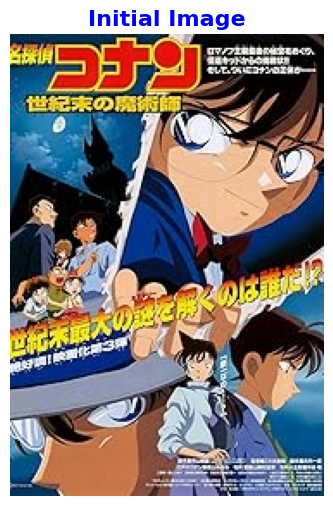

In [18]:
# Combine similarity scores with their corresponding poster IDs
unsorted_results = list(zip(similarity_scores, poster_ids))

# Sort the results in descending order based on similarity scores
sorted_results = sorted(unsorted_results, reverse=False)

# Display the query image (initial image)
plt.figure(figsize=(6, 6))
plt.imshow(Image.open(f"Posters/{poster_id_to_compare}.jpg"))  # Show the query image
plt.title("Initial Image", fontsize=16, fontweight='bold', color='blue')
plt.axis("off")
plt.show()  # Display the plot

Top 5 Similar Posters:
Rank 1: Poster ID = 1692193, Similarity Score = 236.96
Rank 2: Poster ID = 76532, Similarity Score = 240.21
Rank 3: Poster ID = 1621642, Similarity Score = 295.91
Rank 4: Poster ID = 5459730, Similarity Score = 324.89
Rank 5: Poster ID = 3823672, Similarity Score = 325.95


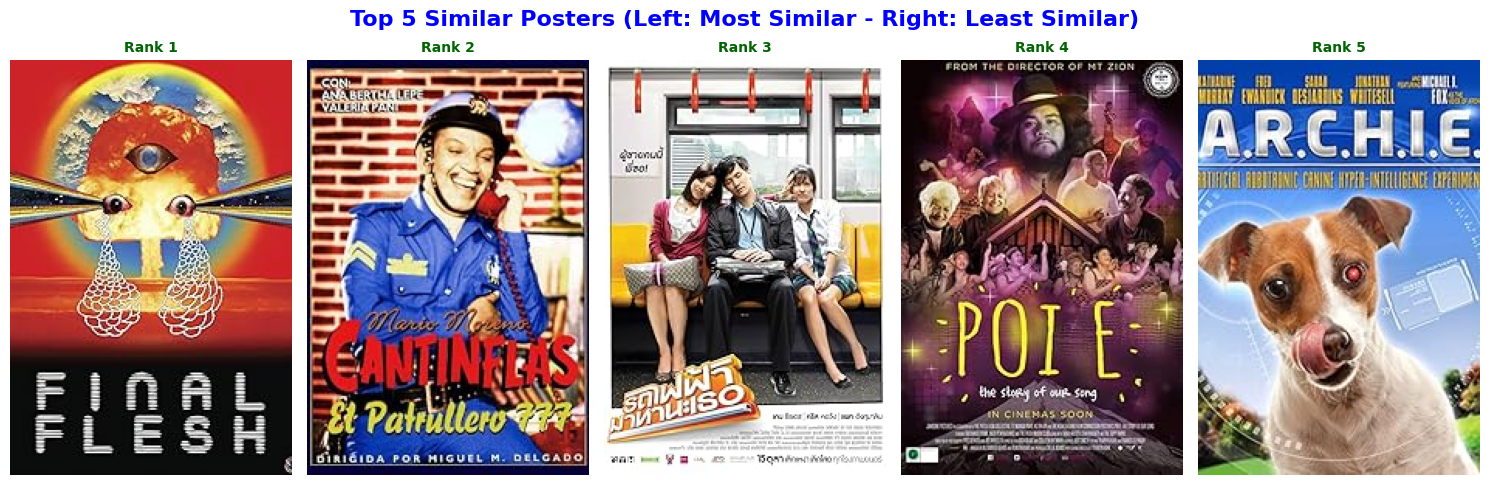

In [19]:
# Print the top 5 similarity scores and their corresponding poster IDs
print("Top 5 Similar Posters:")
for position in range(5):
    similarity_score = sorted_results[position][0][0]  # Extract the numeric similarity score
    poster_id = sorted_results[position][1]  # Extract the poster ID
    print(f"Rank {position + 1}: Poster ID = {poster_id}, Similarity Score = {similarity_score:.2f}")

# Plot the top 5 most similar images side by side with enhanced design
plt.figure(figsize=(15, 5))

# Create subplots for each of the top 5 images
for idx in range(5):
    plt.subplot(1, 5, idx + 1)
    plt.axis("off")
    
    # Load and display the current image
    image_to_plot = Image.open(f"Posters/{sorted_results[idx][1]}.jpg")
    plt.imshow(image_to_plot)
    
    # Add a title to each subplot indicating its rank
    plt.title(f"Rank {idx + 1}", fontsize=10, fontweight='bold', color='darkgreen')

# Add a main title to indicate similarity ranking
plt.suptitle("Top 5 Similar Posters (Left: Most Similar - Right: Least Similar)", 
             fontsize=16, fontweight='bold', color='blue')
plt.tight_layout()
plt.show()